# MACS 30100 
## PS2
## Lerong Wang

In [682]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import pandas as pd

# 1. Income data

## (a) Plot a histogram of percentages of the income.txt data with 30 bins.

In [683]:
income = np.loadtxt('incomes.txt')

<IPython.core.display.Javascript object>


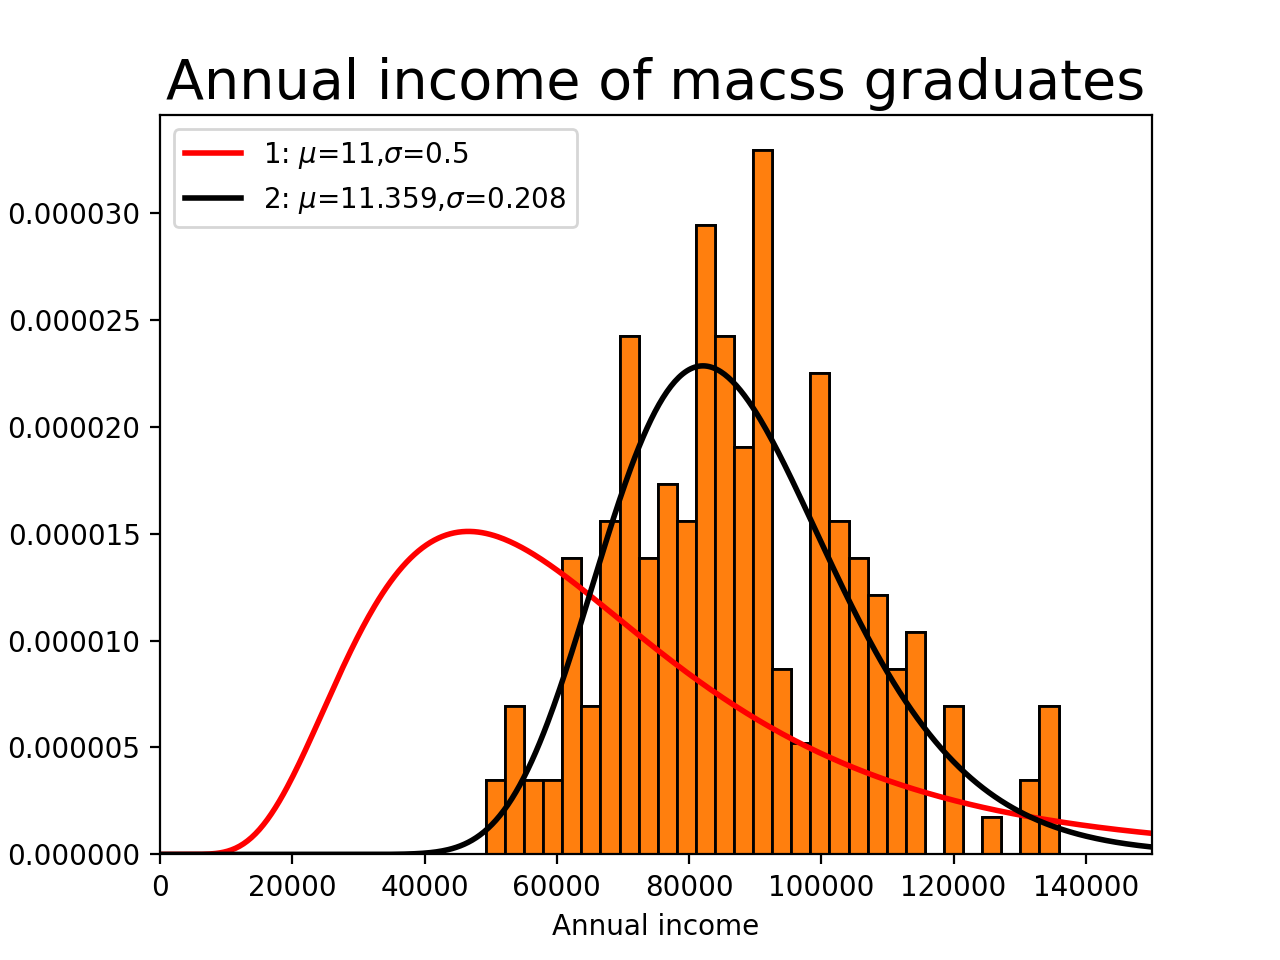

In [684]:
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Annual income of macss graduates', fontsize=20)
plt.xlabel('Annual income')
plt.ylabel('Percent of observations')
plt.show()

## (b) Plot the lognormal PDF for 0 <=  x <= 1500 000. What is the value of the log likelihood value for this parameterization of the distribution and given this data?

In [685]:
def lognorm_pdf(xvals, mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the lognormal pdf with mean mu and
    standard deviation sigma. If the cutoff is finite, then the PDF
    values are inflated upward to reflect the zero probability on values
    above the cutoff. If there is no cutoff given or if it is given as
    infinity, this function does the same thing as
    sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.norm.cdf(0, loc=mu, scale=sigma)
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    pdf_vals    = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [686]:
dist_pts = np.linspace(1e-100, 150000, 500)
mu_1 = 11
sig_1 = 0.5
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_1, sig_1, 150000),
         linewidth=2, color='r', label='1: $\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')
plt.show()

see the plot above for lognormal plot

In [687]:
def log_lik_truncnorm(xvals, mu, sigma, cutoff):
    pdf_vals = lognorm_pdf(xvals, mu, sigma, cutoff)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val
print('the value of the log-likelihood value is', log_lik_truncnorm(income, mu_1, sig_1, 150000))

the value of the log-likelihood value is -2385.85699781


## (c) Estimate the parameters of the lognormal distribution by maximum likelihood and plot its PDF against the PDF from part (b) and the histogram from part (a). Plot the estimated PDF for 0 <= x <= 150; 000. Report the ML estimates for mu and sigma, the value of the likelihood function, and the variance-covariance matrix

In [688]:
def crit(params, *args):
    mu, sigma = params
    xvals, cutoff = args
    log_lik_val = log_lik_truncnorm(xvals, mu, sigma, cutoff)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [689]:
import scipy.optimize as opt

mu_init = 11  # mu_2
sig_init = 0.5  # sig_2
params_init = np.array([mu_init, sig_init])
mle_args = (income, 150000)
results = opt.minimize(crit, params_init, args=(mle_args), method='L-BFGS-B',
                       bounds = ((0.1, None), (0.1, None)))
mu_MLE, sig_MLE = results.x
print('mu_MLE =', mu_MLE, ' sig_MLE =', sig_MLE)

mu_MLE = 11.3590243967  sig_MLE = 0.208178530156


In [690]:
results

      fun: 2241.7193013685201
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00645741,  0.01114131])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 10
   status: 0
  success: True
        x: array([ 11.3590244 ,   0.20817853])

In [691]:
print('the value of the likelihood function is', log_lik_truncnorm(income, mu_MLE, sig_MLE, 150000))

the value of the likelihood function is -2241.71930137


In [692]:
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv = OffDiagNeg*results.hess_inv.todense()
print('the variance-covariance matrix is \n', vcv)

the variance-covariance matrix is 
 [[  2.52831353e-04  -2.76208826e-05]
 [ -2.76208826e-05   1.30457089e-04]]


In [693]:
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Annual income of macss graduates', fontsize=20)
plt.xlabel('Annual income')
plt.ylabel('Percent of observations')
plt.xlim([0, 150000])

# Plot the MLE estimated distribution
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_MLE, sig_MLE, 150000),
         linewidth=2, color='k', label='2: $\mu$=11.359,$\sigma$=0.208')
plt.legend(loc='upper left')
plt.show()

please see the plot above.

## (d) Perform a likelihood ratio test to determine the probability that the data in incomes.txt came from the distribution in part (b).

In [694]:
log_lik_h0 = log_lik_truncnorm(income, 11, 0.5, 150000)
log_lik_mle = log_lik_truncnorm(income, mu_MLE, sig_MLE, 450)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.0


We reject H0 and the data in the incomes.txt is unlikely to come from the distribution in part (b).

## (e) Using that estimated model from part (c), what is the probability that you will earn more than 100,000? What is the probability that you will earn less than 75,000?

In [695]:
p1 =  1 - sts.lognorm.cdf(100000, scale = np.exp(mu_MLE), s = sig_MLE)
p2 = sts.lognorm.cdf(75000, scale = np.exp(mu_MLE), s = sig_MLE)
print("The probability that MACSS students will earn more than $100,000 is", p1)
print("The probability they earn less than $75,000 is", p2)          

The probability that MACSS students will earn more than $100,000 is 0.229870180558
The probability they earn less than $75,000 is 0.260233297923


# 2. Linear regression and MLE

## (a)  Estimate (beta_0; beta_1; beta_2; beta_3; sigma^2) to maximize the likelihood of seeing the data in sick.txt. Report your estimates, the value of the log likelihood function, and the estimated variance covariance matrix of the estimates.

In [696]:
df = pd.read_csv('sick.txt')

In [697]:
def error_vals(sick, age, children, temp_winter, beta_0, beta_1, beta_2, beta_3):
    error_val = sick- beta_0 - beta_1 * age - beta_2 * children - beta_3 * temp_winter
    return error_val

In [698]:
def log_lik_truncnorm2(sick, age, children, temp_winter, beta_0, beta_1, beta_2, beta_3, sigma):
    error_val = error_vals(sick, age, children, temp_winter, beta_0, beta_1, beta_2, beta_3)
    N = len(error_val)
    log_lik_val = (-N/2) * np.log(2 * np.pi) - (N/2) * np.log(sigma ** 2) - \
                  (1 / (2 * sigma ** 2)) * np.sum(error_val ** 2)
    
    return log_lik_val

In [699]:
def crit2(params, *args):
    beta_0, beta_1, beta_2, beta_3, sigma = params
    sick, age, children, temp_winter = args
    log_lik_val = log_lik_truncnorm2(sick, age, children, temp_winter, beta_0, beta_1, beta_2, beta_3, sigma)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [700]:
import scipy.optimize as opt
beta_0_init = 1
beta_1_init = 0
beta_2_init = 0
beta_3_init = 0
sig_init = 0.1 # sig_2
sick_val = df["sick"]
age_val = df["age"]
children_val = df["children"]
temp_winter_val = df["avgtemp_winter"]
params_init = np.array([beta_0_init, beta_1_init, beta_2_init, beta_3_init, sig_init])
mle_args = (sick_val, age_val, children_val, temp_winter_val)
results2 = opt.minimize(crit2, params_init, args=(mle_args), method = 'L-BFGS-B', 
                       bounds = ((None, None), (None, None), (None, None), (None, None), (1e-100, None)))
beta_0_mle, beta_1_mle, beta_2_mle, beta_3_mle, sigma_mle = results2.x

In [701]:
results2

      fun: -876.86506304365412
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -0.78488256, -35.56260708,  -1.23440032, -38.11736633,  -1.26303803])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 690
      nit: 65
   status: 0
  success: True
        x: array([ 0.25164474,  0.01293344,  0.40050126, -0.00999169,  0.00301766])

In [702]:
print('beta_0_mle =', beta_0_MLE, 'beta_1_mle =', beta_1_mle, 'beta_2_mle =', beta_2_mle, 
      'beta_3_mle =', beta_3_mle, '\nsigma_MLE =', sigma_mle)

beta_0_mle = 0.251644785968 beta_1_mle = 0.0129334428085 beta_2_mle = 0.400501256865 beta_3_mle = -0.00999169197321 
sigma_MLE = 0.00301765562013


In [703]:
OffDiagNeg2 = np.eye(5)*2-1
vcv_mle = OffDiagNeg2*results2.hess_inv.todense()
print('the estimated variance covariance matrix of the estimates is \n', vcv_mle)

the estimated variance covariance matrix of the estimates is 
 [[  4.78307511e+02   3.34808215e+01  -4.57002084e+02  -1.62711922e+00
   -1.06072029e+02]
 [  3.34808215e+01   2.41782273e+00   3.29824240e+01   1.45410683e-01
    7.49926624e+00]
 [ -4.57002084e+02   3.29824240e+01   4.49930947e+02  -1.97628763e+00
   -1.02342394e+02]
 [ -1.62711922e+00   1.45410683e-01  -1.97628763e+00   1.89178932e-02
   -3.92423814e-01]
 [ -1.06072029e+02   7.49926624e+00  -1.02342394e+02  -3.92423814e-01
    2.35976466e+01]]


In [704]:
print('The value of Log-likelihood function is', log_lik_truncnorm2(sick, age, children, temp_winter, beta_0_mle,
                                            beta_1_mle, beta_2_mle, beta_3_mle, sig_mle))

The value of Log-likelihood function is 876.865063044


## (b) what is the likelihood that age, number of children, and average winter temperature have no effect on the number of sick days?

In [705]:
log_lik_h0 = log_lik_truncnorm2(sick, age, children, temp_winter, 1.0, 0, 0, 0, 0.01)
log_lik_mle = log_lik_truncnorm2(sick, age, children, temp_winter, beta_0_mle, 
                                beta_1_mle, beta_2_mle, beta_3_mle, sig_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 5)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.0


so H0 is rejected.